## V tem koraku bi rad preveril katera kombinacija fingerprinta in klasifikacijskega modela je najboljša preden začnem manipulirati s podatki. Ta korak je pomemben zato da v nadaljnih korakih vidim kaj izboljšujem

In [1]:
%run __A_knjiznice.py

# Import specific elements from the script
from __A_knjiznice import *
from __B_funkcije import *
import __C_konstante as kon
%matplotlib inline

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import logging
from itertools import product
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Load data
try:
    df = pd.read_csv(f'{kon.path_files}/molekulski_prstni_odtisi/df_circular.csv')
    y = df[['Activity']].values.ravel()  # Assuming 'Activity' is the target
    X = df.iloc[:, 3:]  # Assuming features start from the 4th column
except Exception as e:
    logger.error(f"Error loading data: {e}")
    exit()

# Split the data into interim and test sets
X_interim, X_test, y_interim, y_test = train_test_split(
    X, y, test_size=0.15, random_state=kon.random_seed, shuffle=True, stratify=y
)

# Split the interim data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_interim, y_interim, test_size=15/85, random_state=kon.random_seed, shuffle=True, stratify=y_interim
)

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_categorical('max_depth', [None, 5, 10, 15, 20])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 6)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=kon.random_seed
    )

    # Perform cross-validation
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
    return np.mean(cv_scores)

# Run Optuna to find the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters from Optuna
best_params = study.best_params
logger.info(f"Best parameters from Optuna: {best_params}")

# Train the final model with the best parameters
final_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=kon.random_seed
)

final_rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = final_rf.feature_importances_
features = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

[I 2024-12-09 22:20:54,003] A new study created in memory with name: no-name-d24a9b4b-abe5-4e60-b72d-e5ef18d5a420
[I 2024-12-09 22:20:54,608] Trial 0 finished with value: 0.8557548686796498 and parameters: {'n_estimators': 151, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.8557548686796498.
[I 2024-12-09 22:21:06,154] Trial 1 finished with value: 0.8650681912929545 and parameters: {'n_estimators': 73, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 1 with value: 0.8650681912929545.
[I 2024-12-09 22:21:06,535] Trial 2 finished with value: 0.8240045262342921 and parameters: {'n_estimators': 135, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.8650681912929545.
[I 2024-12-09 22:21:07,178] Trial 3 finished with value: 0.8674867488535524 and parameters: {'n_estimators': 86, 'max_depth': 20, 'min_s

<function matplotlib.pyplot.xlabel(xlabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['left', 'center', 'right'] | None" = None, **kwargs) -> 'Text'>

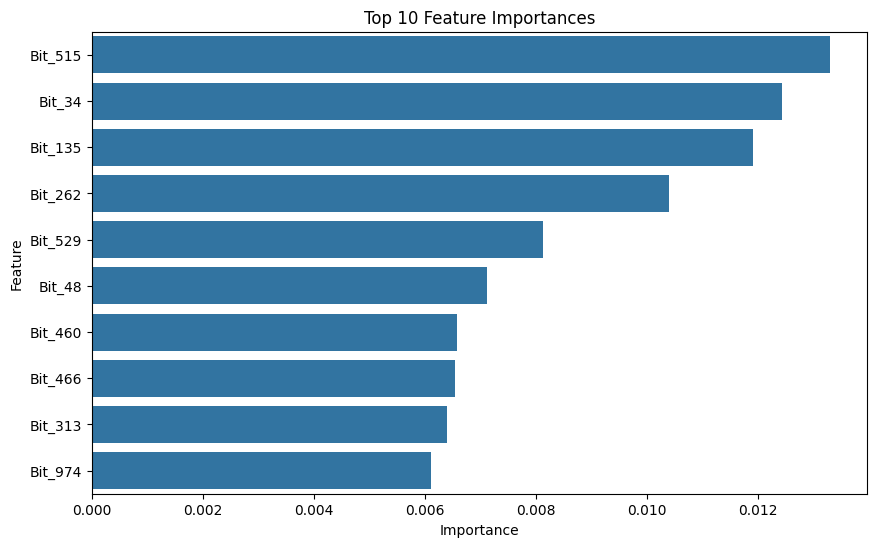

In [3]:
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))  # Top 10 features
plt.title('Top 10 Feature Importances')
plt.xlabel

In [4]:
optuna.visualization.plot_optimization_history(study)
plt.show()

In [5]:
from itertools import product
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import logging



# Define the best parameters from Optuna


# Define a grid search based on the best parameters found
param_grid = {
    'n_estimators': [
        max(1, int(np.floor(best_params['n_estimators'] * 0.9))),  # Lower bound: 90% of the value, rounded down
        best_params['n_estimators'],
        int(np.ceil(best_params['n_estimators'] * 1.1))  # Upper bound: 110% of the value, rounded up
    ],
    'max_depth': [
        max(1, int(np.floor(best_params['max_depth'] * 0.9))) if best_params['max_depth'] is not None else None,  # Lower bound
        best_params['max_depth'],
        int(np.ceil(best_params['max_depth'] * 1.1)) if best_params['max_depth'] is not None else None  # Upper bound
    ],
    'min_samples_split': [
        max(2, int(np.floor(best_params['min_samples_split'] * 0.9))),  # Lower bound: 90% of the value, rounded down
        best_params['min_samples_split'],
        int(np.ceil(best_params['min_samples_split'] * 1.1))  # Upper bound: 110% of the value, rounded up
    ],
    'min_samples_leaf': [
        max(1, int(np.floor(best_params['min_samples_leaf'] * 0.9))),  # Lower bound: 90% of the value, rounded down
        best_params['min_samples_leaf'],
        int(np.ceil(best_params['min_samples_leaf'] * 1.1))  # Upper bound: 110% of the value, rounded up
    ],
    'max_features': [best_params['max_features']],
}

# Create a list of all combinations of parameters for grid search
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf'],
    param_grid['max_features'],
))

# Function to evaluate a single set of parameters
def evaluate_model(params):
    n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features = params
    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=kon.random_seed
    )
    
    try:
        # Perform cross-validation
        cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
        cv_accuracy = np.mean(cv_scores)
        
        # Fit the model on the full training set
        rf.fit(X_train, y_train)
        
        # Evaluate on the validation set
        y_val_pred = rf.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        return {
            "Parameters": {
                "n_estimators": n_estimators,
                "max_depth": max_depth,
                "min_samples_split": min_samples_split,
                "min_samples_leaf": min_samples_leaf,
                "max_features": max_features,
            },
            "CV Accuracy": cv_accuracy,
            "Validation Accuracy": val_accuracy
        }
    except Exception as e:
        logger.error(f"Error with parameters {params}: {e}")
        return None

# Sequentially evaluate the models using grid search
results = []
for params in param_combinations:
    result = evaluate_model(params)
    if result is not None:  # Only append valid results
        results.append(result)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort the results DataFrame by Validation Accuracy in descending order
sorted_results_df = results_df.sort_values(by='Validation Accuracy', ascending=False)

# Log the best result
if not sorted_results_df.empty:
    best_result = sorted_results_df.iloc[0]  # Get the first row after sorting
    logger.info(f"Best Parameters: {best_result['Parameters']}, CV Accuracy: {best_result['CV Accuracy']}, Validation Accuracy: {best_result['Validation Accuracy']}")
else:
    logger.warning("No valid results were found during the grid search.")


2024-12-09 22:29:24,074 - INFO - Best Parameters: {'n_estimators': 262, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}, CV Accuracy: 0.8857757131796795, Validation Accuracy: 0.8842443729903537


In [6]:
sorted_results_df

,Parameters,CV Accuracy,Validation Accuracy
0,"{'n_estimators': 262, 'max_depth': None, 'min_...",0.885776,0.884244
18,"{'n_estimators': 262, 'max_depth': None, 'min_...",0.885776,0.884244
1,"{'n_estimators': 262, 'max_depth': None, 'min_...",0.885776,0.884244
19,"{'n_estimators': 262, 'max_depth': None, 'min_...",0.885776,0.884244
9,"{'n_estimators': 262, 'max_depth': None, 'min_...",0.885776,0.884244
...,...,...,...
38,"{'n_estimators': 292, 'max_depth': None, 'min_...",0.877151,0.868167
53,"{'n_estimators': 292, 'max_depth': None, 'min_...",0.877151,0.868167
41,"{'n_estimators': 292, 'max_depth': None, 'min_...",0.877151,0.868167
50,"{'n_estimators': 292, 'max_depth': None, 'min_...",0.877151,0.868167


In [14]:
# Assuming the best parameters are already identified
best_params = sorted_results_df.iloc[0]['Parameters']

# Fit the best model on the full training set
best_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=kon.random_seed
)

# Fit the model
best_rf.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = best_rf.predict(X_train)
y_train_prob = best_rf.predict_proba(X_train)[:, 1]  # Get probabilities for the positive class
auc_train_score = roc_auc_score(y_train, y_train_prob)
conf_matrix_train = confusion_matrix(y_train, y_train_pred)

# Make predictions on the validation set
y_val_pred = best_rf.predict(X_val)
y_val_prob = best_rf.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class
auc_score = roc_auc_score(y_val, y_val_prob)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)

# Make predictions on the test set
y_test_pred = best_rf.predict(X_test)
y_test_prob = best_rf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
auc_test_score = roc_auc_score(y_test, y_test_prob)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

# Plotting the confusion matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Plotting the ROC curve
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

Training Accuracy: 0.9993098688750862
Training F1 Score: 0.9993206521739131
Training Precision: 0.9986422267481331
Training Recall: 1.0


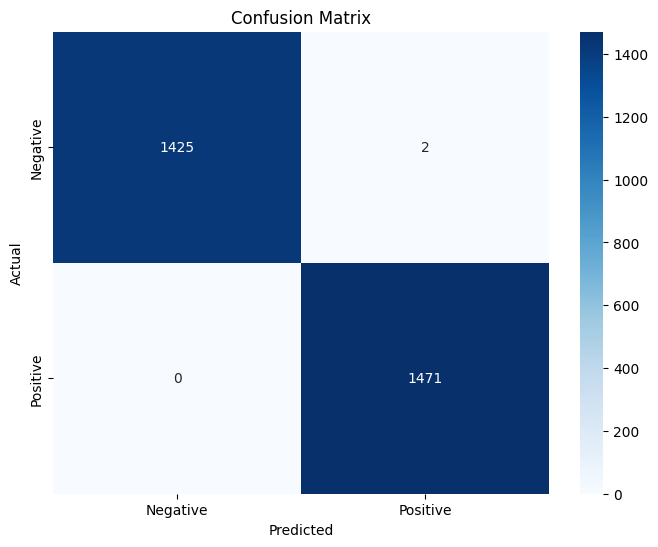

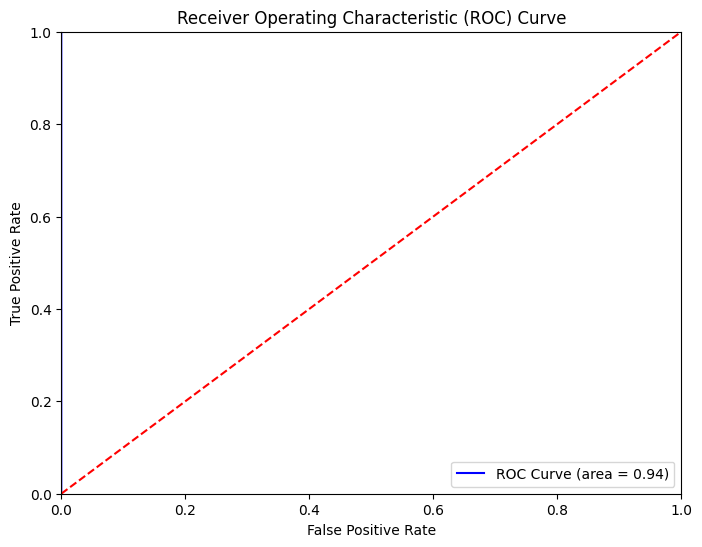

In [16]:
accuracy_train = accuracy_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)

print("Training Accuracy:", accuracy_train)
print("Training F1 Score:", f1_train)
print("Training Precision:", precision_train)
print("Training Recall:", recall_train)
# Plotting the confusion matrix for training data
plot_confusion_matrix(conf_matrix_train)
plot_roc_curve(y_train, y_train_prob)

Validation Accuracy: 0.8842443729903537
Validation F1 Score: 0.886435331230284
Validation Precision: 0.8836477987421384
Validation Recall: 0.8892405063291139


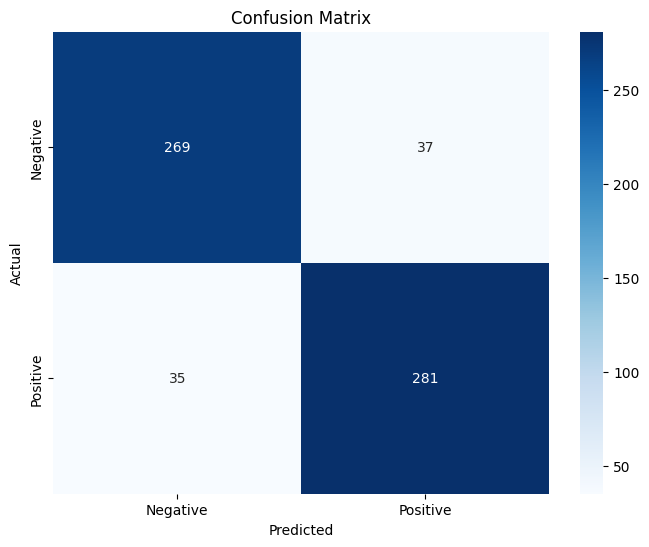

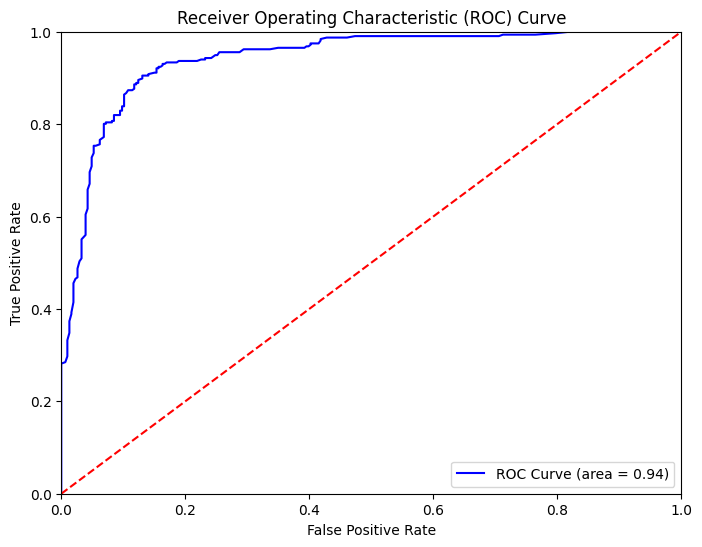

In [17]:
# Calculate metrics for validation data
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)

print("Validation Accuracy:", accuracy_val)
print("Validation F1 Score:", f1_val)
print("Validation Precision:", precision_val)
print("Validation Recall:", recall_val)

# Plotting the confusion matrix for validation data
plot_confusion_matrix(conf_matrix_val)
plot_roc_curve(y_val, y_val_prob)

# Pregled rezulattov na podatkih za testiranje

Test Accuracy: 0.8729903536977492
Test F1 Score: 0.8744038155802861
Test Precision: 0.8785942492012779
Test Recall: 0.870253164556962


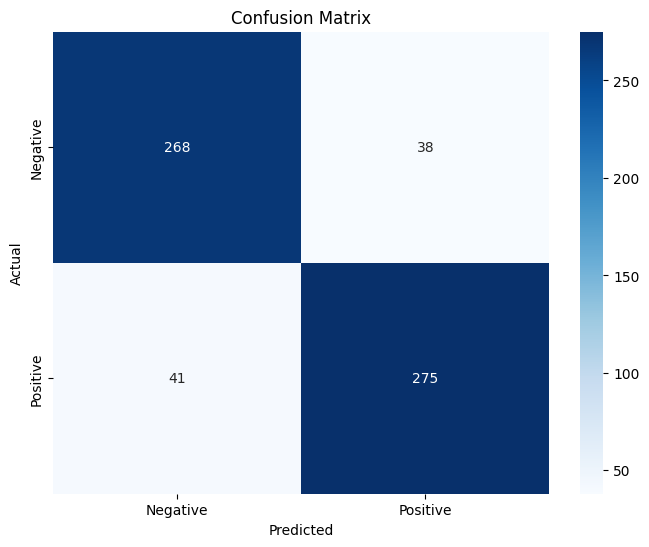

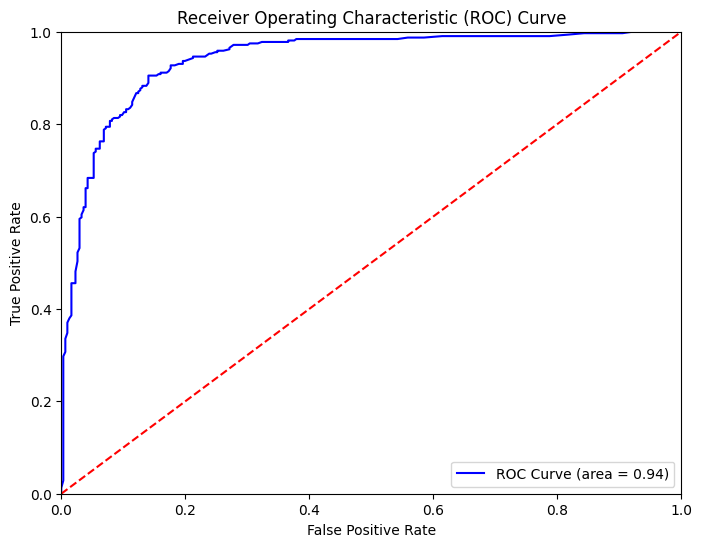

In [13]:
# Calculate metrics for test data
accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)

print("Test Accuracy:", accuracy_test)
print("Test F1 Score:", f1_test)
print("Test Precision:", precision_test)
print("Test Recall:", recall_test)

plot_confusion_matrix(conf_matrix_test)
plot_roc_curve(y_test, y_test_prob)
